# Feature Reduction Steps:
1. Standardize features by removing the mean and scaling to unit variance
1. Select only 25% the original number of peptides
1. Grid Search classifier hyper-parameters

In [13]:
import Classification_Utils as cu
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import time

## Load Dataframe

In [14]:
df = pd.read_csv('FullPeptideQuant.txt', sep='\t', index_col='Peptide')
print(df.shape)

(55676, 253)


## Map each column to a corresponding label

In [15]:
tissues = ['Blood_Plasma', 'Blood_Serum', 'CSF', 'Liver', 'Monocyte', 'Ovary', 'Pancreas', 'Substantia_Nigra', 'Temporal_Lobe']
 
tissues_to_columns = cu.map_tissues_to_columns(df, tissues)

In [16]:
column_names = df.columns.values.tolist()
labels = cu.get_labels(column_names, tissues_to_columns)

In [17]:
df.head()

,Blood_Plasma_CPTAC_TrypDige_undepleted_normal_19Apr13_Methow_13-02-13,Blood_Plasma_Darpa_2_human_02_23Jan17_Arwem_16-10-25,Blood_Plasma_OMICS_EBV_HP_UW001_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW002_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW003_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW004_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW005_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW006_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW007_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW008_8Apr16_Arwen_16-01-03,...,Temporal_Lobe_Alz_FX1P159_Guan_1_26Jul10_Andromeda_10-06-28,Temporal_Lobe_Alz_FX1P159_Guan_2_26Jul10_Andromeda_10-06-29,Temporal_Lobe_Alz_FX1P159_Guan_3_26Jul10_Andromeda_10-06-28,Temporal_Lobe_Alz_FX1P159_Guan_Typx2_1_26Jul10_Andromeda_10-06-29,Temporal_Lobe_Alz_FX1P159_Guan_Typx2_2_26Jul10_Andromeda_10-06-28,Temporal_Lobe_Alz_FX1P159_Guan_Typx2_3_26Jul10_Andromeda_10-06-29,Temporal_Lobe_Alz_FX2P57_IMAC_153_9May11_Hawk_11-04-02p,Temporal_Lobe_Alz_FX2P57_IMAC_161_20Apr11_Hawk_10-12-03p,Temporal_Lobe_Alz_FX2P57_IMAC_187_26Apr11_Hawk_10-12-03p,Temporal_Lobe_Alz_FX2P57_IMAC_212_11May11_Hawk_11-04-02p
Peptide,,,,,,,,,,,,,,,,,,,,,
-.DIQM*TQSPSTLSASVGDR.V,26.731951,22.187643,3.022208,29.328345,29.916272,3.022208,27.586706,30.458361,29.004130,31.023004,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
-.DIQM*TQSPSTLSASVGDRVTITCR.A,3.022208,3.022208,3.022208,30.633308,30.815586,3.022208,29.483431,32.564995,30.319263,32.368436,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
-.DIQMTQSPSTLSASVGDR.V,26.387537,28.015792,3.022208,3.022208,31.403752,3.022208,27.695976,29.779972,29.747784,30.255299,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
-.DIQMTQSPSTLSASVGDRVTITCR.A,3.022208,3.022208,3.022208,3.022208,32.585511,3.022208,3.022208,30.845879,30.983525,27.526416,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
-.EVQLVETGGGLIQPGGSLR.L,24.546220,3.022208,3.022208,3.022208,26.732727,3.022208,28.163126,23.836245,3.022208,28.436388,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208


## Make train-test split

In [18]:
train_df, test_df, train_labels, test_labels = train_test_split(
    df.T, labels, test_size=0.30, random_state=0, stratify=labels)

## Tune parameters of best models with Grid Search

In [19]:
N_JOBS = 1

from sklearn.model_selection import StratifiedShuffleSplit
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)

### Gradient Boosting grid search

In [38]:
from sklearn.ensemble import GradientBoostingClassifier

gbc_pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('reduce_dim', SelectPercentile(percentile=25)),
    ('classify', GradientBoostingClassifier(random_state=0))])
 
MAX_DEPTH = range(5,16,3)
N_ESTIMATORS = [25, 50, 100, 200]
MIN_SAMPLES_SPLIT = [2, 3, 4, 5, 10]
    
gbc_param_grid = {
    'classify__n_estimators': N_ESTIMATORS,
    'classify__min_samples_split': MIN_SAMPLES_SPLIT,
    'classify__max_depth': MAX_DEPTH 
}

gbc_grid = GridSearchCV(gbc_pipe, 
                       cv=cv, 
                       n_jobs=N_JOBS, 
                       param_grid=gbc_param_grid)

gbc_grid.fit(train_df, train_labels)

print('Best Gradient Boosting parameters:\n', gbc_grid.best_params_)
print('\nBest Cross-Validation score:\n', gbc_grid.best_score_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [11515 43238] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Best Gradient Boosting parameters:
 {'classify__max_depth': 5, 'classify__min_samples_split': 5, 'classify__n_estimators': 50}

Best Cross-Validation score:
 0.937037037037037


In [39]:
finalized_model_folder = r'Trained_Models\\'
model_path = finalized_model_folder + 'gbc_grid_25Percentile.sav'
joblib.dump(gbc_grid, open(model_path, 'wb'))

###  Logistic Regression grid search

In [40]:
from sklearn.linear_model import LogisticRegression

SOLVERS = ['liblinear', 'sag', 'saga']
C_OPTIONS = [.01, .1, 1, 10, 100, 1000]
    
lr_pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('reduce_dim', SelectPercentile(percentile=25)),
    ('classify', LogisticRegression(random_state=0))])


lr_param_grid = {
    'classify__solver': SOLVERS,
    'classify__C': C_OPTIONS
}

lr_grid = GridSearchCV(lr_pipe, 
                       cv=cv, 
                       n_jobs=N_JOBS, 
                       param_grid=lr_param_grid)
                       
lr_grid.fit(train_df, train_labels)

print('Best Logistic Regression parameters:\n', lr_grid.best_params_)
print('\nBest Cross-Validation score:\n', lr_grid.best_score_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 1667

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  134   200   349   559   617  2131  2322  2504  3070  3511  4582  4781
  4837  5144  5192  5359  5567  5673  5821  6098  6405  6601  7337  7388
  7463  8342  8423  9170 10056 10145 11140 11204 11215 11266 11318 11515
 12432 12690 12955 13381 13942 14573 15474 15956 17682 19430 19648 20866
 21636 22570 23185 23563 24218 25154 25328 25607 26410 26552 27191 27782
 27900 28075 28181 28236 28741 29035 29154 29335 29430 30098 30213 30559
 31369 31655 31994 32771 32819 33326 33521 33667 34534 35302 36181 36402
 36871 37399 37414 37530 37788 38028 38031 39297 39612 40160 40306 40355
 40594 41023 41350 41461 43238 43746 43793 44590 44851 46997 47235 47385
 48573 4985

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  116   134   525   643   770  1823  2088  2202  2322  2743  2832  2900
  2932  2999  3306  3435  5267  6550  7158  7560  7600  7735  8599  8713
  9992 11215 11266 11419 11498 11515 11675 12560 12666 13146 14573 15958
 17351 19320 19430 21136 21528 22275 22306 23029 23988 24138 25607 25986
 27900 28661 28719 28954 29097 29154 29401 29678 29894 30977 31194 31344
 32683 32697 33780 34498 35134 37016 37109 37127 37394 41459 43047 43238
 47051 47140 47161 47399 47514 47517 47757 48116 48328 48381 48631 48632
 48734 48736 49769 50191 51636 51841 52880 53209 53268 53588 53594 54494
 54514 54545 54571 54847 54869 55049] are constant.
  UserWarning)
C:\ProgramData\An

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  349   350   402   477   558   981  1072  1258  1287  1344  1528  1546
  1639  1823  2002  2063  2064  2095  2112  2113  2131  2375  2398  2446
  2574  2918  3178  3557  4837  4994  5293  5585  5654  5673  5714  5830
  5904  6232  6276  6405  6500  6537  7339  7560  7618  7843  7999  8175
  9043 10077 10098 10300 10355 10376 10463 10534 10701 11515 11708 12354
 13408 14011 14386 14450 14573 14604 14983 15150 15531 15670 16085 16672
 16746 16757 16953 17090 17240 17351 17395 17754 18100 18125 18302 18347
 18557 18900 18921 19024 19416 19430 19536 19674 19792 19959 20238 20457
 20578 20708 20818 22010 22366 22504 22506 22667 22671 22746 22969 22985
 23248 23576 23645 24050 24213 24400 24415 24451 24628 25154 25328 25413
 25430 25477 25607 26294 26450 26559 26639 26888 27087 27285 27919 28181
 28287 28624 28644 29021 29035 29154 29316 29317 29320 29466 29623 29742
 297

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  356   637   675  1064  1339  1546  1985  2126  2212  2215  2985  5261
  5415  5628  7065  7463  7600  8235  9427  9661  9885 10358 10492 10900
 11266 11304 11318 11515 11535 12544 12942 13364 13919 13942 14482 14794
 15504 15791 16582 16809 17682 18566 18592 18751 19097 20173 20305 20328
 22267 22654 23305 23563 24508 24928 25130 25455 25969 26201 26270 27372
 28346 29845 30278 30770 30946 31946 32209 32738 33564 34122 34194 34214
 34581 35062 35462 35555 35781 37183 37664 37757 37783 38727 40594 40783
 41071 42131 42212 42424 42582 43238 43921 44371 44420 44760 45151 45337
 46085 46259 46656 48043 48349 48709 49529 49548 50369 50500 50858 51534
 52709 52836 53561 53567 54229 54874 55132] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_di

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  116   134   525   643   770  1823  2088  2202  2322  2743  2832  2900
  2932  2999  3306  3435  5267  6550  7158  7560  7600  7735  8599  8713
  9992 11215 11266 11419 11498 11515 11675 12560 12666 13146 14573 15958
 17351 19320 19430 21136 21528 22275 22306 23029 23988 24138 25607 25986
 27900 28661 28719 28954 29097 29154 29401 29678 29894 30977 31194 31344
 32683 32697 33780 34498 35134 37016 37109 37127 37394 41459 43047 43238
 47051 47140 47161 47399 47514 47517 47757 48116 48328 48381 48631 48632
 48734 48736 49769 50191 51636 51841 52880 53209 53268 53588 53594 54494
 54514 54545 54571 54847 54869 55049] are constant.
  UserWarning)
C:\ProgramData\An

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  349   350   402   477   558   981  1072  1258  1287  1344  1528  1546
  1639  1823  2002  2063  2064  2095  2112  2113  2131  2375  2398  2446
  2574  2918  3178  3557  4837  4994  5293  5585  5654  5673  5714  5830
  5904  6232  6276  6405  6500  6537  7339  7560  7618  7843  7999  8175
  9043 10077 10098 10300 10355 10376 10463 10534 10701 11515 11708 12354
 13408 14011 14386 14450 14573 14604 14983 15150 15531 15670 16085 16672
 16746 16757 16953 17090 17240 17351 17395 17754 18100 18125 18302 18347
 18557 18900 18921 19024 19416 19430 19536 19674 19792 19959 20238 20457
 20578 20708 20818 22010 22366 22504 22506 22667 22671 22746 22969 22985
 23248 2357

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 4566

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  116   134   544   552   553  1159  1243  1261  1263  1380  1434  1435
  1447  1625  1696  1719  1866  1880  2199  2500  3306  3483  4781  5189
  5231  5293  6024  6098  6311  7735  7843 10377 10410 10924 10964 11362
 11515 11662 11926 11975 12282 12354 14203 14573 14990 15504 15543 16684
 18936 19484 20866 20867 21323 21966 22039 22535 22938 23591 24218 24312
 24595 25175 25738 26007 27278 27560 28390 28443 28661 28973 29137 29294
 29301 29401 29485 29649 29653 29678 29732 29748 29761 30073 30121 30161
 30376 31574 32598 33457 33592 33740 33780 33794 33859 34410 36040 36246
 36676 36701 36966 37772 37788 38146 38529 39172 39306 39474 40198 40230
 40661 40709 40873 41350 41910 43238 43729 44590 46136 46635 47385 47514
 48372 48381 48528 48737 48850 49022 49051 50015 51471 51750 52071 52280
 53175 53214 53350 53408 53636 54306 54514 54884 55599] are constant.
  UserW

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  134   200   349   559   617  2131  2322  2504  3070  3511  4582  4781
  4837  5144  5192  5359  5567  5673  5821  6098  6405  6601  7337  7388
  7463  8342  8423  9170 10056 10145 11140 11204 11215 11266 11318 11515
 12432 12690 12955 13381 13942 14573 15474 15956 17682 19430 19648 20866
 21636 22570 23185 23563 24218 25154 25328 25607 26410 26552 27191 27782
 27900 28075 28181 28236 28741 29035 29154 29335 29430 30098 30213 30559
 31369 31655 31994 32771 32819 33326 33521 33667 34534 35302 36181 36402
 36871 37399 37414 37530 37788 38028 38031 39297 39612 40160 40306 40355
 40594 41023 41350 41461 43238 43746 43793 44590 44851 46997 47235 47385
 48573 49852 50015 50214 50635 51326 51471 51605 52295 52836 53215 53251
 53637 53902 54076 54731 54859 55373 55646 55658] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\un

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  116   134   525   643   770  1823  2088  2202  2322  2743  2832  2900
  2932  2999  3306  3435  5267  6550  7158  7560  7600  7735  8599  8713
  9992 11215 11266 11419 11498 11515 11675 12560 12666 13146 14573 15958
 17351 19320 19430 21136 21528 22275 22306 23029 23988 24138 25607 25986
 27900 28661 28719 28954 29097 29154 29401 29678 29894 30977 31194 31344
 32683 32697 33780 34498 35134 37016 37109 37127 37394 41459 43047 43238
 47051 47140 47161 47399 47514 47517 47757 48116 48328 48381 48631 48632
 48734 48736 49769 50191 51636 51841 52880 53209 53268 53588 53594 54494
 54514 54545 54571 54847 54869 55049] are constant.
  UserWarning)
C:\ProgramData\An

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  349   350   402   477   558   981  1072  1258  1287  1344  1528  1546
  1639  1823  2002  2063  2064  2095  2112  2113  2131  2375  2398  2446
  2574  2918  3178  3557  4837  4994  5293  5585  5654  5673  5714  5830
  5904  6232  6276  6405  6500  6537  7339  7560  7618  7843  7999  8175
  9043 10077 10098 10300 10355 10376 10463 10534 10701 11515 11708 12354
 13408 14011 14386 14450 14573 14604 14983 15150 15531 15670 16085 16672
 16746 16757 16953 17090 17240 17351 17395 17754 18100 18125 18302 18347
 18557 18900 18921 19024 19416 19430 19536 19674 19792 19959 20238 20457
 20578 20708 20818 22010 22366 22504 22506 22667 22671 22746 22969 22985
 23248 2357

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 4566

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  116   134   544   552   553  1159  1243  1261  1263  1380  1434  1435
  1447  1625  1696  1719  1866  1880  2199  2500  3306  3483  4781  5189
  5231  5293  6024  6098  6311  7735  7843 10377 10410 10924 10964 11362
 11515 11662 11926 11975 12282 12354 14203 14573 14990 15504 15543 16684
 18936 19484 20866 20867 21323 21966 22039 22535 22938 23591 24218 24312
 24595 25175 25738 26007 27278 27560 28390 28443 28661 28973 29137 29294
 29301 29401 29485 29649 29653 29678 29732 29748 29761 30073 30121 30161
 30376 31574 32598 33457 33592 33740 33780 33794 33859 34410 36040 36246
 36676 36701 36966 37772 37788 38146 38529 39172 39306 39474 40198 40230
 40661 40709 40873 41350 41910 43238 43729 44590 46136 46635 47385 47514
 48372 48381 48528 48737 48850 49022 49051 50015 51471 51750 52071 52280
 53175 53214 53350 53408 53636 54306 54514 54884 55599] are constant.
  UserW

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  134   200   349   559   617  2131  2322  2504  3070  3511  4582  4781
  4837  5144  5192  5359  5567  5673  5821  6098  6405  6601  7337  7388
  7463  8342  8423  9170 10056 10145 11140 11204 11215 11266 11318 11515
 12432 12690 12955 13381 13942 14573 15474 15956 17682 19430 19648 20866
 21636 22570 23185 23563 24218 25154 25328 25607 26410 26552 27191 27782
 27900 28075 28181 28236 28741 29035 29154 29335 29430 30098 30213 30559
 31369 31655 31994 32771 32819 33326 33521 33667 34534 35302 36181 36402
 36871 37399 37414 37530 37788 38028 38031 39297 39612 40160 40306 40355
 40594 41023 41350 41461 43238 43746 43793 44590 44851 46997 47235 47385
 48573 49852 50015 50214 50635 51326 51471 51605 52295 52836 53215 53251
 53637 53902 54076 54731 54859 55373 55646 55658] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\un

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  116   134   525   643   770  1823  2088  2202  2322  2743  2832  2900
  2932  2999  3306  3435  5267  6550  7158  7560  7600  7735  8599  8713
  9992 11215 11266 11419 11498 11515 11675 12560 12666 13146 14573 15958
 17351 19320 19430 21136 21528 22275 22306 23029 23988 24138 25607 25986
 27900 28661 28719 28954 29097 29154 29401 29678 29894 30977 31194 31344
 32683 32697 33780 34498 35134 37016 37109 37127 37394 41459 43047 43238
 47051 47140 47161 47399 47514 47517 47757 48116 48328 48381 48631 48632
 48734 48736 49769 50191 51636 51841 52880 53209 53268 53588 53594 54494
 54514 54545 54571 54847 54869 55049] are constant.
  UserWarning)
C:\ProgramData\An

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  349   350   402   477   558   981  1072  1258  1287  1344  1528  1546
  1639  1823  2002  2063  2064  2095  2112  2113  2131  2375  2398  2446
  2574  2918  3178  3557  4837  4994  5293  5585  5654  5673  5714  5830
  5904  6232  6276  6405  6500  6537  7339  7560  7618  7843  7999  8175
  9043 10077 10098 10300 10355 10376 10463 10534 10701 11515 11708 12354
 13408 14011 14386 14450 14573 14604 14983 15150 15531 15670 16085 16672
 16746 16757 16953 17090 17240 17351 17395 17754 18100 18125 18302 18347
 18557 18900 18921 19024 19416 19430 19536 19674 19792 19959 20238 20457
 20578 20708 20818 22010 22366 22504 22506 22667 22671 22746 22969 22985
 23248 2357

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 4566

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  116   134   544   552   553  1159  1243  1261  1263  1380  1434  1435
  1447  1625  1696  1719  1866  1880  2199  2500  3306  3483  4781  5189
  5231  5293  6024  6098  6311  7735  7843 10377 10410 10924 10964 11362
 11515 11662 11926 11975 12282 12354 14203 14573 14990 15504 15543 16684
 18936 19484 20866 20867 21323 21966 22039 22535 22938 23591 24218 24312
 24595 25175 25738 26007 27278 27560 28390 28443 28661 28973 29137 29294
 29301 29401 29485 29649 29653 29678 29732 29748 29761 30073 30121 30161
 30376 31574 32598 33457 33592 33740 33780 33794 33859 34410 36040 36246
 36676 36701 36966 37772 37788 38146 38529 39172 39306 39474 40198 40230
 40661 40709 40873 41350 41910 43238 43729 44590 46136 46635 47385 47514
 48372 48381 48528 48737 48850 49022 49051 50015 51471 51750 52071 52280
 53175 53214 53350 53408 53636 54306 54514 54884 55599] are constant.
  UserW

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  134   200   349   559   617  2131  2322  2504  3070  3511  4582  4781
  4837  5144  5192  5359  5567  5673  5821  6098  6405  6601  7337  7388
  7463  8342  8423  9170 10056 10145 11140 11204 11215 11266 11318 11515
 12432 12690 12955 13381 13942 14573 15474 15956 17682 19430 19648 20866
 21636 22570 23185 23563 24218 25154 25328 25607 26410 26552 27191 27782
 27900 28075 28181 28236 28741 29035 29154 29335 29430 30098 30213 30559
 31369 31655 31994 32771 32819 33326 33521 33667 34534 35302 36181 36402
 36871 37399 37414 37530 37788 38028 38031 39297 39612 40160 40306 40355
 40594 41023 41350 41461 43238 43746 43793 44590 44851 46997 47235 47385
 48573 49852 50015 50214 50635 51326 51471 51605 52295 52836 53215 53251
 53637 53902 54076 54731 54859 55373 55646 55658] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\un

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  116   134   525   643   770  1823  2088  2202  2322  2743  2832  2900
  2932  2999  3306  3435  5267  6550  7158  7560  7600  7735  8599  8713
  9992 11215 11266 11419 11498 11515 11675 12560 12666 13146 14573 15958
 17351 19320 19430 21136 21528 22275 22306 23029 23988 24138 25607 25986
 27900 28661 28719 28954 29097 29154 29401 29678 29894 30977 31194 31344
 32683 32697 33780 34498 35134 37016 37109 37127 37394 41459 43047 43238
 47051 47140 47161 47399 47514 47517 47757 48116 48328 48381 48631 48632
 48734 48736 49769 50191 51636 51841 52880 53209 53268 53588 53594 54494
 54514 54545 54571 54847 54869 55049] are constant.
  UserWarning)
C:\ProgramData\An

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  349   350   402   477   558   981  1072  1258  1287  1344  1528  1546
  1639  1823  2002  2063  2064  2095  2112  2113  2131  2375  2398  2446
  2574  2918  3178  3557  4837  4994  5293  5585  5654  5673  5714  5830
  5904  6232  6276  6405  6500  6537  7339  7560  7618  7843  7999  8175
  9043 10077 10098 10300 10355 10376 10463 10534 10701 11515 11708 12354
 13408 14011 14386 14450 14573 14604 14983 15150 15531 15670 16085 16672
 16746 16757 16953 17090 17240 17351 17395 17754 18100 18125 18302 18347
 18557 18900 18921 19024 19416 19430 19536 19674 19792 19959 20238 20457
 20578 20708 20818 22010 22366 22504 22506 22667 22671 22746 22969 22985
 23248 2357

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 4566

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  116   134   544   552   553  1159  1243  1261  1263  1380  1434  1435
  1447  1625  1696  1719  1866  1880  2199  2500  3306  3483  4781  5189
  5231  5293  6024  6098  6311  7735  7843 10377 10410 10924 10964 11362
 11515 11662 11926 11975 12282 12354 14203 14573 14990 15504 15543 16684
 18936 19484 20866 20867 21323 21966 22039 22535 22938 23591 24218 24312
 24595 25175 25738 26007 27278 27560 28390 28443 28661 28973 29137 29294
 29301 29401 29485 29649 29653 29678 29732 29748 29761 30073 30121 30161
 30376 31574 32598 33457 33592 33740 33780 33794 33859 34410 36040 36246
 36676 36701 36966 37772 37788 38146 38529 39172 39306 39474 40198 40230
 40661 40709 40873 41350 41910 43238 43729 44590 46136 46635 47385 47514
 48372 48381 48528 48737 48850 49022 49051 50015 51471 51750 52071 52280
 53175 53214 53350 53408 53636 54306 54514 54884 55599] are constant.
  UserW

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  134   200   349   559   617  2131  2322  2504  3070  3511  4582  4781
  4837  5144  5192  5359  5567  5673  5821  6098  6405  6601  7337  7388
  7463  8342  8423  9170 10056 10145 11140 11204 11215 11266 11318 11515
 12432 12690 12955 13381 13942 14573 15474 15956 17682 19430 19648 20866
 21636 22570 23185 23563 24218 25154 25328 25607 26410 26552 27191 27782
 27900 28075 28181 28236 28741 29035 29154 29335 29430 30098 30213 30559
 31369 31655 31994 32771 32819 33326 33521 33667 34534 35302 36181 36402
 36871 37399 37414 37530 37788 38028 38031 39297 39612 40160 40306 40355
 40594 41023 41350 41461 43238 43746 43793 44590 44851 46997 47235 47385
 48573 49852 50015 50214 50635 51326 51471 51605 52295 52836 53215 53251
 53637 53902 54076 54731 54859 55373 55646 55658] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\un

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  116   134   525   643   770  1823  2088  2202  2322  2743  2832  2900
  2932  2999  3306  3435  5267  6550  7158  7560  7600  7735  8599  8713
  9992 11215 11266 11419 11498 11515 11675 12560 12666 13146 14573 15958
 17351 19320 19430 21136 21528 22275 22306 23029 23988 24138 25607 25986
 27900 28661 28719 28954 29097 29154 29401 29678 29894 30977 31194 31344
 32683 32697 33780 34498 35134 37016 37109 37127 37394 41459 43047 43238
 47051 47140 47161 47399 47514 47517 47757 48116 48328 48381 48631 48632
 48734 48736 49769 50191 51636 51841 52880 53209 53268 53588 53594 54494
 54514 54545 54571 54847 54869 55049] are constant.
  UserWarning)
C:\ProgramData\An

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  349   350   402   477   558   981  1072  1258  1287  1344  1528  1546
  1639  1823  2002  2063  2064  2095  2112  2113  2131  2375  2398  2446
  2574  2918  3178  3557  4837  4994  5293  5585  5654  5673  5714  5830
  5904  6232  6276  6405  6500  6537  7339  7560  7618  7843  7999  8175
  9043 10077 10098 10300 10355 10376 10463 10534 10701 11515 11708 12354
 13408 14011 14386 14450 14573 14604 14983 15150 15531 15670 16085 16672
 16746 16757 16953 17090 17240 17351 17395 17754 18100 18125 18302 18347
 18557 18900 18921 19024 19416 19430 19536 19674 19792 19959 20238 20457
 20578 20708 20818 22010 22366 22504 22506 22667 22671 22746 22969 22985
 23248 2357

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 4566

Best Logistic Regression parameters:
 {'classify__C': 1, 'classify__solver': 'liblinear'}

Best Cross-Validation score:
 0.9833333333333333


In [41]:
finalized_model_folder = r'Trained_Models\\'
model_path = finalized_model_folder + 'lr_grid_25Percentile.sav'
joblib.dump(lr_grid, open(model_path, 'wb'))

### Random Forest grid search

In [42]:
from sklearn.ensemble import RandomForestClassifier

MAX_FEATURES = ['auto', 'sqrt', 'log2']

rf_pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('reduce_dim', SelectPercentile(percentile=25)),
    ('classify', RandomForestClassifier(random_state=0))])

    
rf_param_grid = {
    'classify__n_estimators': N_ESTIMATORS,
    'classify__min_samples_split': MIN_SAMPLES_SPLIT,
    'classify__max_features': MAX_FEATURES
}

rf_grid = GridSearchCV(rf_pipe, 
                       cv=cv, 
                       n_jobs=N_JOBS, 
                       param_grid=rf_param_grid)

rf_grid.fit(train_df, train_labels)

print('Best Random Forest parameters:\n', rf_grid.best_params_)
print('\nBest Cross-Validation score:\n', rf_grid.best_score_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [11515 43238] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Best Random Forest parameters:
 {'classify__max_features': 'auto', 'classify__min_samples_split': 4, 'classify__n_estimators': 200}

Best Cross-Validation score:
 0.9722222222222222


In [43]:
model_path = finalized_model_folder + 'rf_grid_25Percentile.sav'
joblib.dump(rf_grid, open(model_path, 'wb'))

### SVC grid search

In [44]:
from sklearn.svm import SVC

KERNELS = ['linear', 'rbf', 'poly']

svc_pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('reduce_dim', SelectPercentile(percentile=25)),
    ('classify', SVC(random_state=0))])
 
svc_param_grid = {
    'classify__kernel': KERNELS,
    'classify__C': C_OPTIONS
}

svc_grid = GridSearchCV(svc_pipe, 
                       cv=cv, 
                       n_jobs=N_JOBS, 
                       param_grid=svc_param_grid)

svc_grid.fit(train_df, train_labels)

print('Best SVC parameters:\n', svc_grid.best_params_)
print('\nBest Cross-Validation score:\n', svc_grid.best_score_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [11515 43238] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Best SVC parameters:
 {'classify__C': 0.01, 'classify__kernel': 'linear'}

Best Cross-Validation score:
 0.9722222222222222


In [45]:
model_path = finalized_model_folder + 'svc_grid_25Percentile.sav'
joblib.dump(svc_grid, open(model_path, 'wb'))

### KNN grid search

In [29]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('reduce_dim', SelectPercentile(percentile=25)),
    ('classify', KNeighborsClassifier())])
 
N_NEIGHBORS = [1, 3, 5, 10, 20]
 
knn_param_grid = {
    'classify__n_neighbors': N_NEIGHBORS
}

knn_grid = GridSearchCV(knn_pipe, 
                       cv=cv, 
                       n_jobs=N_JOBS, 
                       param_grid=knn_param_grid)

knn_grid.fit(train_df, train_labels)

print('Best KNN parameters:\n', knn_grid.best_params_)
print('\nBest Cross-Validation score:\n', knn_grid.best_score_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

Best KNN parameters:
 {'classify__n_neighbors': 1}

Best Cross-Validation score:
 0.9518518518518518


In [30]:
model_path = finalized_model_folder + 'knn_grid_25Percentile.sav'
joblib.dump(svc_grid, open(model_path, 'wb'))

### Multinomial Naive Bayes grid search

In [31]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

mnb_pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('reduce_dim', SelectPercentile(percentile=25)),
    ('scale', MinMaxScaler()),
    ('classify', MultinomialNB())])
 
ALPHAS = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
 
mnb_param_grid = {
    'classify__alpha': ALPHAS
}

mnb_grid = GridSearchCV(mnb_pipe, 
                       cv=cv, 
                       n_jobs=N_JOBS, 
                       param_grid=mnb_param_grid)

mnb_grid.fit(train_df, train_labels)

print('Best Multinomial NB parameters:\n', mnb_grid.best_params_)
print('\nBest Cross-Validation score:\n', mnb_grid.best_score_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  740  2068  2209  2240  2918  3034  3850  4010  4994  5677  6276  6537
  7158  7283  7339  7600  7664  7999  9885 10292 10355 11055 11515 12048
 12086 12327 12354 12942 14386 14604 14983 15150 15831 16953 17240 18213
 18302 18592 18762 19024 19430 19791 19959 20218 20319 20457 20578 20783
 21144 22671 22746 23474 24213 24415 24451 25583 25607 25686 26559 26639
 26732 27609 29021 29154 29317 29466 29750 29761 30794 31220 31329 32923
 34167 35112 35756 36258 36382 38146 38258 38407 39058 39774 40608 40963
 41401 42707 42741 43032 43238 43267 45399 45661 46465 46587 48276 48528
 49051 49132 49238 49326 49736 50357 50762 51984 52124 52915 53712 54198
 54638 55278 55329 55665] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   116   315   356   553   637   749   782  1061  1243  1380  1450
  2008  2199  2504  4582  5192  5585  5651  5969  6098  6311  7877  8377
  9290  9390  9427 10486 10710 11409 11515 12025 12086 12312 14555 15905
 16355 16450 16874 17904 18100 18232 18256 18347 19970 20783 21899 22344
 24875 25154 25686 26007 27610 27783 28075 28181 28661 28913 29137 29138
 29308 29401 29461 29545 29678 29750 30171 30598 31278 32402 33144 33268
 33780 33791 33838 34205 34730 34902 34952 35420 35458 36382 36428 36646
 36969 37414 37521 37595 37718 37776 37788 37790 38104 38420 40231 40617
 40709 41485 41799 42212 42720 42774 43238 44242 44308 44590 45402 45432
 45480 45661 45739 45778 46465 46475 46583 47385 47487 47514 47547 48295
 48349 48379 48380 48381 49587 49790 49872 51471 51605 52053 52824 52947
 53213 53295 53636 53744 53955 54393 55227] are constant.
  UserWarning)
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   98   108   350   402   477   617   749   791  1145  1258  1287  1306
  1313  1483  1502  1544  1546  1560  1598  1603  1639  1644  1693  1715
  1786  1796  1823  1831  1836  1839  1903  1914  1984  2016  2047  2063
  2064  2095  2112  2113  2215  2255  2375  2398  2446  2504  2523  2911
  3879  4354  4425  4512  4582  4837  4962  4994  5261  5567  5585  5714
  6232  6405  6928  7104  7333  7600  7769  7871  7877  7999  8175  8282
  8332  8347  9620  9885 10077 10376 10423 10534 10640 10701 10748 10777
 10924 11000 11297 11304 11384 11409 11515 11708 11849 12086 12312 12942
 12989 13403 13408 14386 14604 15107 15159 15504 15531 15670 16085 16238
 16450 16672 16746 16757 16779 17395 17589 17754 18100 18125 18181 18557
 18592 18744 18921 18948 19024 19080 19157 19426 19430 19536 19622 19675
 19815 19970 20578 20822 20966 21053 21770 21785 22010 22280 22346 22654
 227

Best Multinomial NB parameters:
 {'classify__alpha': 0.1}

Best Cross-Validation score:
 0.9851851851851852


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [11515 43238] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [32]:
model_path = finalized_model_folder + 'mnb_grid_25Percentile.sav'
joblib.dump(mnb_grid, open(model_path, 'wb'))

## Gaussian Naive Bayes - no hyper-parameters to tune

In [33]:
from sklearn.naive_bayes import GaussianNB

gnb_pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('reduce_dim', SelectPercentile(percentile=25)),
    ('classify', GaussianNB())])

gnb_pipe.fit(train_df, train_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [11515 43238] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reduce_dim', SelectPercentile(percentile=25,
         score_func=<function f_classif at 0x000000C9E3ED9840>)), ('classify', GaussianNB(priors=None))])

In [34]:
model_path = finalized_model_folder + 'gnb_25Percentile.sav'
joblib.dump(gnb_pipe, open(model_path, 'wb'))

## Classify Training Set

### Use models from notebook to predict new data

### Fit test data to optimized train data

In [46]:
lr_grid_pred = lr_grid.predict(test_df)
lr_grid_result = lr_grid.score(test_df, test_labels)

rf_grid_pred = rf_grid.predict(test_df)
rf_grid_result = rf_grid.score(test_df, test_labels)

svc_grid_pred = svc_grid.predict(test_df)
svc_grid_result = svc_grid.score(test_df, test_labels)

knn_grid_pred = knn_grid.predict(test_df)
knn_grid_result = knn_grid.score(test_df, test_labels)

gbc_grid_pred = gbc_grid.predict(test_df)
gbc_grid_result = gbc_grid.score(test_df, test_labels)

gnb_grid_pred = gnb_pipe.predict(test_df)
gnb_grid_result = gnb_pipe.score(test_df, test_labels)

mnb_grid_pred = mnb_grid.predict(test_df)
mnb_grid_result = mnb_grid.score(test_df, test_labels)

In [47]:
print(lr_grid_result)
print(rf_grid_result)
print(svc_grid_result)
print(knn_grid_result)
print(gbc_grid_result)
print(gnb_grid_result)
print(mnb_grid_result)

1.0
1.0
1.0
1.0
0.9868421052631579
0.9210526315789473
1.0


##  Confusion matrices of model's predictions on new data

Confusion matrix, without normalization
[[9 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 9 0]
 [0 0 0 0 0 0 0 0 9]]
Normalized confusion matrix
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]


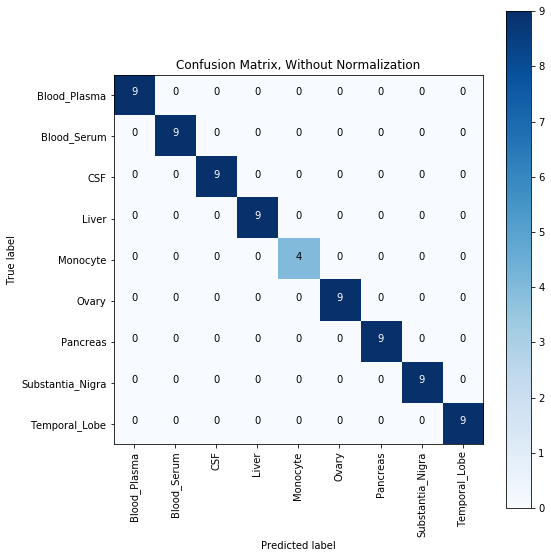

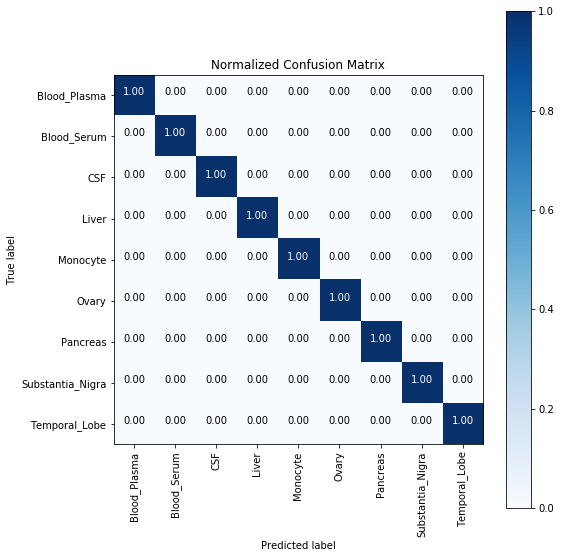

In [37]:
cu.show_confusion_matrices(test_labels, mnb_grid_pred, tissues)